In [1]:
from tqdm import tqdm
import pandas as pd
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
api = wandb.Api()

# Pull and Dedup Data

In [2]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    # "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [3]:
# Composable_Interventions has all the results
project_paths = [
    'dri-ice/Composable_Interventions',
    # 'dri-ice/AK_Tests'
]

filter_dict = { "state": "finished" }
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    
    # Iterate over eachrun and capture the config and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-05-31 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True
            
            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")

# Sort by 'tag' and '_timestamp' in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=['tag', '_timestamp'], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit='s')
all_runs_df_sorted = all_runs_df.sort_values(by=['_timestamp'], ascending=[False])
all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["qa_question_count_limit"].isnull()]

dri-ice/Composable_Interventions:  95%|█████████▍| 351/371 [00:02<00:00, 129.49it/s]

Error processing run n0iel6ok: '_timestamp'
Error processing run xr5mede5: '_timestamp'
Error processing run 27f8pxs0: '_timestamp'


dri-ice/Composable_Interventions: 100%|██████████| 371/371 [00:03<00:00, 122.48it/s]


In [4]:
# TODO: Ensure that rmu_layer_id is 3. This was originaly set to 5, but Kyle decided to rerun the evals last minute with a better hyperparameter.
# Use older RMU experiments
# all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["rmu_layer_id"] != 3]

In [5]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset="tag", keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "Lora",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
}
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics
all_runs_df_deduplicated.value_counts("tag")

/tmp/ipykernel_218893/787060927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))
/tmp/ipykernel_218893/787060927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
/tmp/ipykernel_218893/787060927.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

tag
AWQ2bit-to-ft             1
ft-to-GPTQ8bit            1
lora-to-GPTQ8bit          1
lora-to-SparseGPT0.25%    1
lora-to-SparseGPT0.35%    1
                         ..
Wanda0.25%-to-memit       1
Wanda0.35%-to-ft          1
Wanda0.35%-to-lora        1
Wanda0.35%-to-memit       1
wanda0.75\%-rmu           1
Length: 209, dtype: int64

In [6]:
# TODO: Get a second pair of eyes on this this math

# Math for determining number of interventions
awq_settings = 5
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

66
48


In [7]:
data = all_runs_df_deduplicated

categories = {
    "No Intervention": data[data["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": data[data["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": data[data["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": data[data["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": data[data["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": data[data["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": data[data["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": data[data["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": data[data["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": data[data["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
# assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

# display(categories["Compression to Edit"])
# Missing Wanda0.25%-to-lora, Wanda0.45%-to-lora, Wanda0.65%-to-lora, 
# assert len(categories["Compression to Edit"]) == (editor_count // 2 )- 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 1, f"{len(categories['Unlearn'])} != 1"
assert len(categories["Edit to Unlearn"]) == 3
assert len(categories["Unlearn to Edit"]) == 3, f"{len(categories['Unlearn to Edit'])} != 3"

# display(categories["Compress to Unlearn"])
# assert len(categories["Compress to Unlearn"]) == rmu_count // 2, f"{len(categories['Compress to Unlearn'])} != {rmu_count // 2}"

# display(categories["Unlearn to Compress"])
# assert len(categories["Unlearn to Compress"]) == rmu_count // 2, f"{len(categories['Unlearn to Compress'])} != {rmu_count // 2}"


# Create Results Tables

In [8]:
def format_flops(value):
    """ Format FLOPs with three significant figures and appropriate suffix. """
    try:
        if isinstance(value, str):
            value = clean_numeric_value(value)
        if abs(value) < 1e6:  # Less than 1 million (below Mega)
            return "{:.3g}k".format(value / 1e3)
        elif abs(value) < 1e9:  # Mega to Giga range
            return "{:.3g}M".format(value / 1e6)
        elif abs(value) < 1e12:  # Giga to Tera range
            return "{:.3g}G".format(value / 1e9)
        else:  # Tera and above
            return "{:.3g}T".format(value / 1e12)
    except Exception as e:
        print(f"Error formatting FLOPs value {value}: {e}")
        return "---"

def escape_latex_special_chars(s):
    """ Escape special characters in LaTeX strings. """
    return str(s).replace('%', '\\%').replace('_', '\\_').replace('&', '\\&').replace('#', '\\#').replace('$', '\\$')

def clean_numeric_value(value):
    """ Convert a string with units to a numeric value. """
    try:
        value = str(value)
        if ' TFLOPS' in value:
            return float(value.replace(' TFLOPS', '')) * 1e12
        if ' GFLOPS' in value:
            return float(value.replace(' GFLOPS', '')) * 1e9
        if ' MFLOPS' in value:
            return float(value.replace(' MFLOPS', '')) * 1e6
        if ' kFLOPS' in value:
            return float(value.replace(' kFLOPS', '')) * 1e3
        return pd.to_numeric(value, errors='coerce')
    except Exception as e:
        print(f"Error cleaning value {value}: {e}")
        return pd.NA

def categorize_and_generate_latex(data):
    # Define categories based on the provided criteria
    categories = {
    "No Intervention": data[data['interventions'].apply(lambda x: x == [])].copy(),
    "Editing": data[data['interventions'].apply(lambda x: x == ['edit'])].copy(),
    "Compression": data[data['interventions'].apply(lambda x: x == ['compress'])].copy(),
    "Edit to Compression": data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])].copy(),
    "Compression to Edit": data[data['interventions'].apply(lambda x: x == ['compress', 'edit'])].copy(),
    "Unlearn": data[data['interventions'].apply(lambda x: x == ['unlearn'])].copy(),
    "Edit to Unlearn": data[data['interventions'].apply(lambda x: x == ['edit', 'unlearn'])].copy(),
    "Unlearn to Edit": data[data['interventions'].apply(lambda x: x == ['unlearn', 'edit'])].copy(),
    "Compress to Unlearn": data[data['interventions'].apply(lambda x: x == ['compress', 'unlearn'])].copy(),
    "Unlearn to Compress": data[data['interventions'].apply(lambda x: x == ['unlearn', 'compress'])].copy()
}
    # Clean numeric columns
    for col in ["FLOPs", "Latency"]:
        if col in data.columns:
            data.loc[:, col] = data[col].apply(clean_numeric_value)
            data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric

    # Column mappings
    column_mappings = {
        "Success": "Rewrite accuracy",
        "Generalization": "Generalization",
        "Locality": "Locality",
        "Avg. Bits": "Average bits",
        "FLOPs": "FLOPs",
        "PPL": "PPL",
        "MMLU": "mmlu accuracy",
        "WMDP Bio": "wmdp_bio accuracy",
        "WMDP Cyber": "wmdp_cyber accuracy"
    }
    latex_columns = ["Success", "Generalization", "Locality", "Avg. Bits", "FLOPs", "PPL", "MMLU", "WMDP Bio", "WMDP Cyber"]

    # Initialize output string
    output_str = ""

    for category, group in categories.items():
        if group.empty:
            continue
        # output_str += f"\\textbf{{{category}}} \\\\ \\midline\n"
        for _, row in group.iterrows():
            # Calculate mean and std for each relevant column within the group
            stats = {}
            for latex_col, csv_col in column_mappings.items():
                if csv_col in row.index:
                    value = row[csv_col]
                    if pd.isna(value):
                        stats[latex_col] = "---"
                    else:
                        # Custom formatting for FLOPs and Latency
                        if latex_col == "FLOPs":
                            mean_str = format_flops(value)
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        elif latex_col == "Latency":
                            mean_str = f"{value:.3f}s"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        else:
                            mean_str = f"{value:.3f}"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                else:
                    stats[latex_col] = "---"

            # Prepare the LaTeX row for the current group
            latex_row = escape_latex_special_chars(row['tag'])  # Use the tag name directly without escaping
            for column in latex_columns:
                latex_row += " & " + stats.get(column, "---")
            latex_row += " \\\\"

            # Append to output string
            output_str += latex_row + "\n"
        
        output_str += "\\midrule\n"

    return output_str

latex_rows_with_categories = categorize_and_generate_latex(all_runs_df_deduplicated)
print(latex_rows_with_categories)

None & 0.009 & 0.021 & 0.027 & 16.000 & 1.92T & 5.540 & 0.621 & 0.714 & 0.442 \\
\midrule
lora\_Edit & 1.000 & 0.647 & 0.030 & 16.000 & 1.79T & 21.656 & 0.607 & 0.700 & 0.444 \\
memit\_Edit & 0.990 & 0.887 & 0.050 & 16.000 & 1.92T & 5.570 & 0.602 & 0.687 & 0.435 \\
ft\_Edit & 1.000 & 0.769 & 0.117 & 16.000 & 1.92T & 5.570 & 0.611 & 0.690 & 0.438 \\
\midrule
Compress\_GPTQ8bit & 0.009 & 0.021 & 0.024 & 8.250 & -0.001k & 5.539 & 0.622 & 0.713 & 0.439 \\
Compress\_GPTQ4bit & 0.000 & 0.009 & 0.018 & 4.250 & -0.001k & 14.088 & 0.600 & 0.682 & 0.441 \\
Compress\_GPTQ2bit & 0.000 & 0.000 & 0.023 & 2.250 & -0.001k & 2089.334 & 0.237 & 0.254 & 0.255 \\
Compress\_AWQ4bit & 0.000 & 0.011 & 0.027 & 4.250 & -0.001k & 5.911 & 0.598 & 0.687 & 0.456 \\
Compress\_AWQ8bit & 0.009 & 0.021 & 0.027 & 8.250 & -0.001k & 5.540 & 0.621 & 0.713 & 0.444 \\
Compress\_AWQ2bit & 0.000 & 0.000 & 0.000 & 2.250 & -0.001k & 1748954.750 & 0.269 & 0.240 & 0.246 \\
Compress\_SparseGPT0.65\% & 0.009 & 0.004 & 0.018 & 6.250

/tmp/ipykernel_218893/1870216397.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, col] = data[col].apply(clean_numeric_value)
/tmp/ipykernel_218893/1870216397.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric


# Create Plots

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the font family to serif
plt.rcParams['font.family'] = 'serif'

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")

# plotting constants
TITLE_FONT_SIZE = 24
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 4
MARKER_SIZE = 8
X_LABEL_ROTATION = 20

# Plot: 3x2 heatmaps

['Lora', 'Fine-tune', 'MEMIT', 'RMU', 'GPTQ', 'Wanda', 'SparseGPT', 'AWQ']


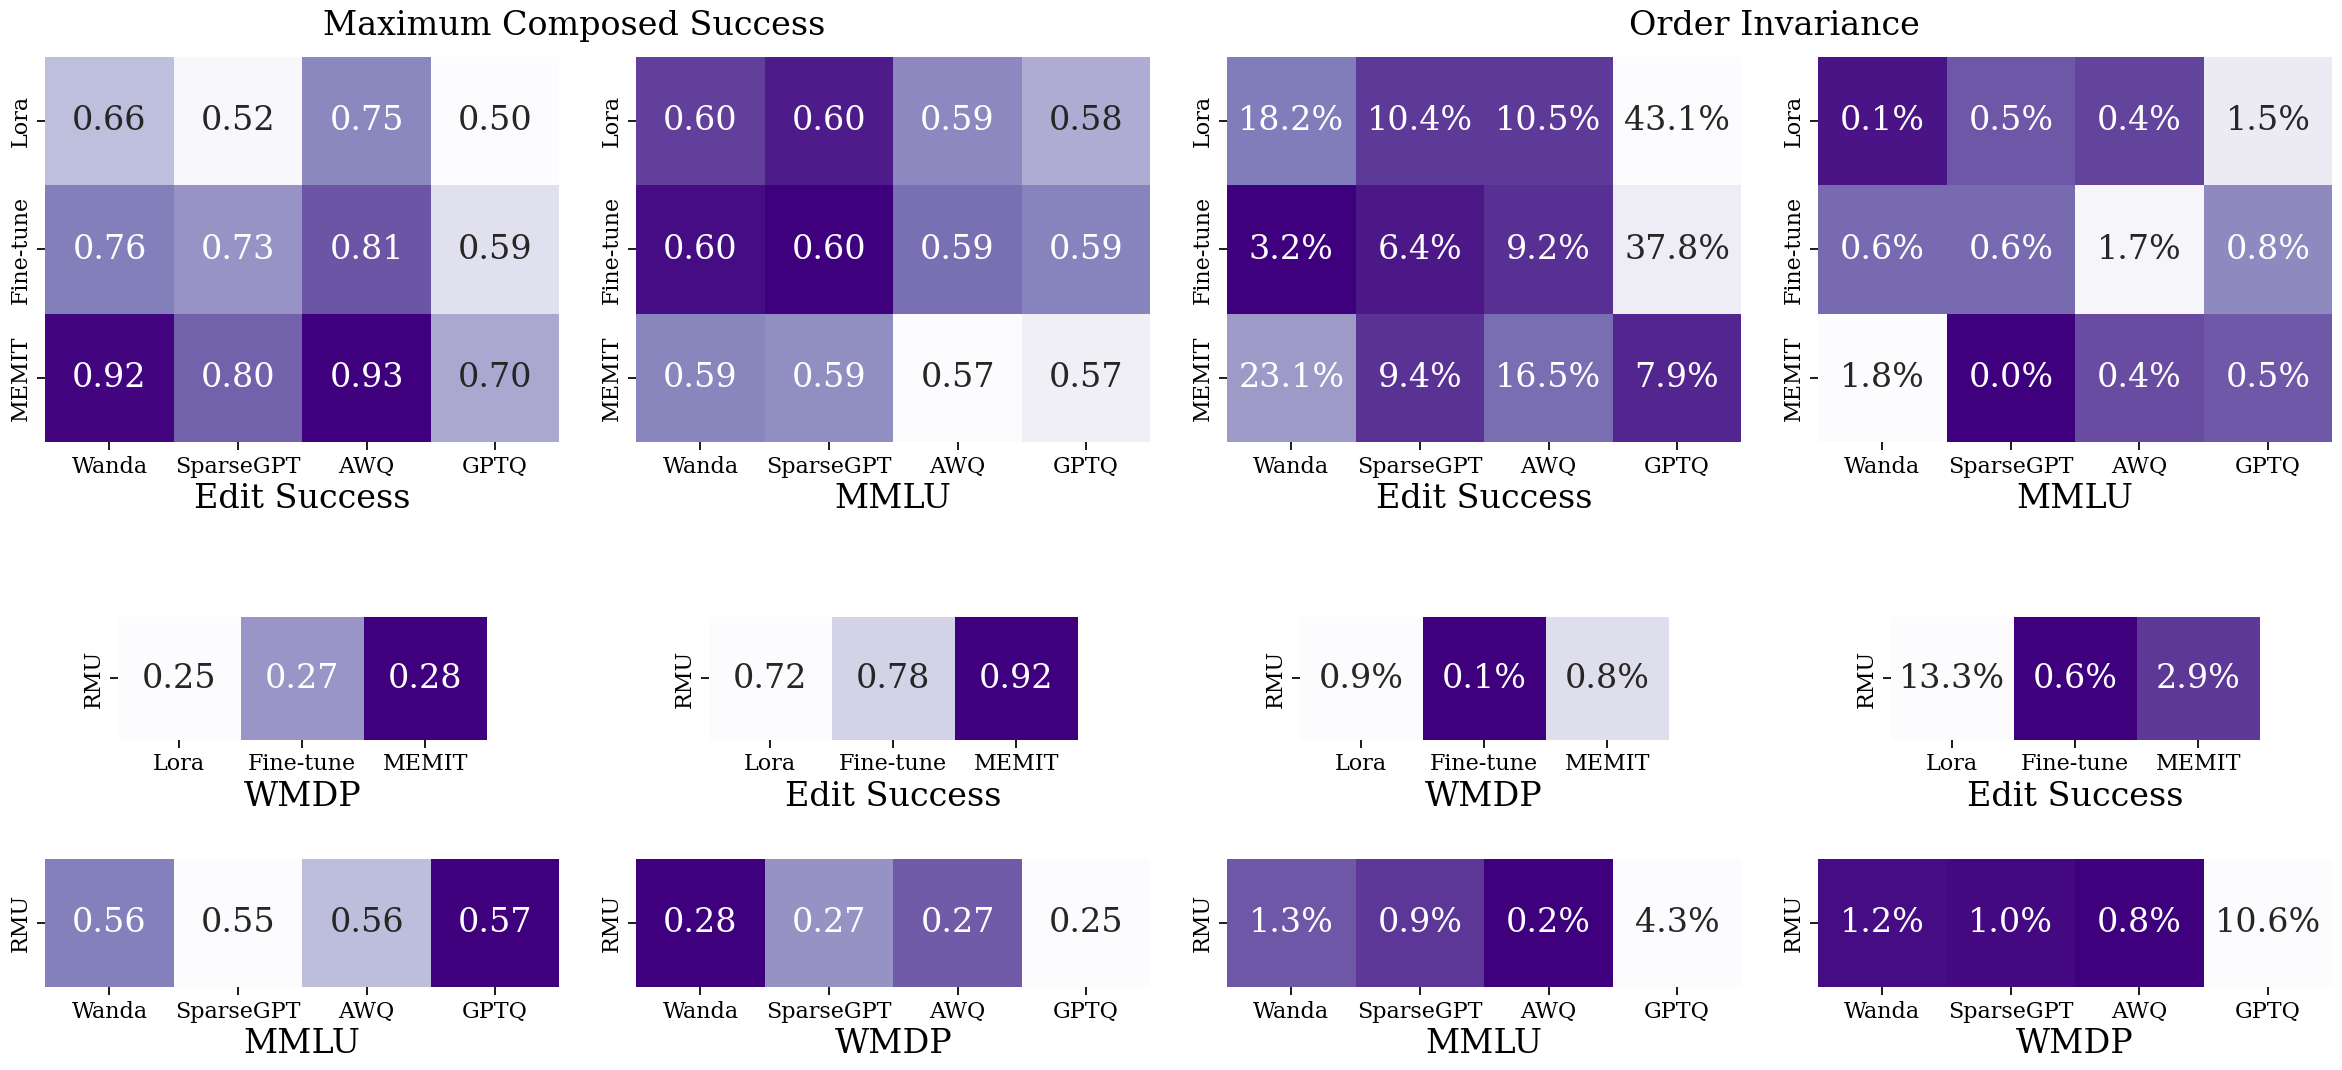

In [16]:
intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "Lora": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn"
}
default_value = None

print(intervention_names)
intervention_names = ['Lora', 'Fine-tune', 'MEMIT', 'RMU', 'Wanda', 'SparseGPT', 'AWQ', 'GPTQ']

### HEATMAPS for best values
mmlu_heatmap_data_best = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_heatmap_data_best = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_heatmap_data_best = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_heatmap_data_best = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]

        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        mmlu_diff = max(compositions["mmlu accuracy"].iloc[0], compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_heatmap_data_best[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = min(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2), ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_heatmap_data_best[first_intervention][second_intervention] = avg_wmdp_diff

        rewrite_diff = max(compositions["Rewrite accuracy"].iloc[0], compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_heatmap_data_best[first_intervention][second_intervention] = rewrite_diff

        general_diff = max(compositions["Generalization"].iloc[0], compositions["Generalization"].iloc[1]).round(4)
        generalization_heatmap_data_best[first_intervention][second_intervention] = general_diff

### HEATMAPS for invariance
mmlu_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]

        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_heatmap_data[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_heatmap_data[first_intervention][second_intervention] = avg_wmdp_diff

        rewrite_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_heatmap_data[first_intervention][second_intervention] = rewrite_diff
    
        general_diff = abs(compositions["Generalization"].iloc[0] - compositions["Generalization"].iloc[1]).round(4)
        generalization_heatmap_data[first_intervention][second_intervention] = general_diff

### PLOTTING       
# 
# # Set larger font sizes
plt.rcParams['font.size'] = 24  # Adjust as desired for overall font size
plt.rcParams['axes.titlesize'] = 10  # Title font size
plt.rcParams['axes.labelsize'] = 16  # Axis label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size 
plt.rcParams['ytick.labelsize'] = 16  # Tick label font size 
# Create three heatmaps next two eachother, one for each frame
fig, axes = plt.subplots(3, 4, figsize=(6 * FIG_SIZE, 3*FIG_SIZE), gridspec_kw={'height_ratios': [3,0.6,1.2]})
y_labels = {
    0: "Edit Success",
    1: "WMDP",
    2: "MMLU"
}

y_labels_upper = {
    1: "Edit Success",
    2: "WMDP",
    0: "MMLU"
}

edit_locs = slice(0, 3)
unlearn_locs = slice(3, 4)
compress_locs = slice(4, 8)

cmap='Purples'
cmap_r='Purples_r'

sns.heatmap(generalization_heatmap_data_best.iloc[edit_locs, compress_locs], annot=True, fmt=".2f", cmap=cmap, ax=axes[0, 0], cbar=False, square=True)
sns.heatmap(wmdp_heatmap_data_best.iloc[edit_locs, unlearn_locs].T, annot=True, fmt=".2f", cmap=cmap, ax=axes[1, 0], cbar=False, square=True)
sns.heatmap(mmlu_heatmap_data_best.iloc[unlearn_locs, compress_locs], annot=True, fmt=".2f", cmap=cmap, ax=axes[2, 0], cbar=False, square=True)

sns.heatmap(mmlu_heatmap_data_best.iloc[edit_locs, compress_locs], annot=True, fmt=".2f", cmap=cmap, ax=axes[0, 1], cbar=False, square=True)
sns.heatmap(generalization_heatmap_data_best.iloc[edit_locs, unlearn_locs].T, annot=True, fmt=".2f", cmap=cmap, ax=axes[1, 1], cbar=False, square=True)
sns.heatmap(wmdp_heatmap_data_best.iloc[unlearn_locs, compress_locs], annot=True, fmt=".2f", cmap=cmap, ax=axes[2, 1], cbar=False, square=True)

sns.heatmap(generalization_heatmap_data.iloc[edit_locs, compress_locs], annot=True, fmt=".1%", cmap=cmap_r, ax=axes[0, 2], cbar=False, square=True)
sns.heatmap(wmdp_heatmap_data.iloc[edit_locs, unlearn_locs].T, annot=True, fmt=".1%", cmap=cmap_r, ax=axes[1, 2], cbar=False, square=True)
sns.heatmap(mmlu_heatmap_data.iloc[unlearn_locs, compress_locs], annot=True, fmt=".1%", cmap=cmap_r, ax=axes[2, 2], cbar=False, square=True)

sns.heatmap(mmlu_heatmap_data.iloc[edit_locs, compress_locs], annot=True, fmt=".1%", cmap=cmap_r, ax=axes[0, 3], cbar=False, square=True)
sns.heatmap(generalization_heatmap_data.iloc[edit_locs, unlearn_locs].T, annot=True, fmt=".1%", cmap=cmap_r, ax=axes[1, 3], cbar=False, square=True)
sns.heatmap(wmdp_heatmap_data.iloc[unlearn_locs, compress_locs], annot=True, fmt=".1%", cmap=cmap_r, ax=axes[2, 3], cbar=False, square=True)

# roate x labels
# for ax in axes:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=X_LABEL_ROTATION)

# Apply y_labels to each subplot in the first row
for i in range(3):
    axes[i, 0].set_xlabel(y_labels[i], fontsize=TITLE_FONT_SIZE)
    axes[i, 1].set_xlabel(y_labels_upper[i], fontsize=TITLE_FONT_SIZE)
    axes[i, 2].set_xlabel(y_labels[i], fontsize=TITLE_FONT_SIZE)
    axes[i, 3].set_xlabel(y_labels_upper[i], fontsize=TITLE_FONT_SIZE)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

# Add titles for the top two rows and bottom two rows on the left side
fig.text(0.25, 0.9, 'Maximum Composed Success', va='center', ha='center', fontsize=TITLE_FONT_SIZE, rotation='horizontal')
fig.text(0.75, 0.9, 'Order Invariance', va='center', ha='center', fontsize=TITLE_FONT_SIZE, rotation='horizontal')
fig.tight_layout()




if not os.path.exists("figures"):
    os.makedirs("figures")
plt.savefig("figures/double_heatmaps.png", bbox_inches="tight")


['Lora', 'Fine-tune', 'MEMIT', 'RMU', 'GPTQ', 'Wanda', 'SparseGPT', 'AWQ']


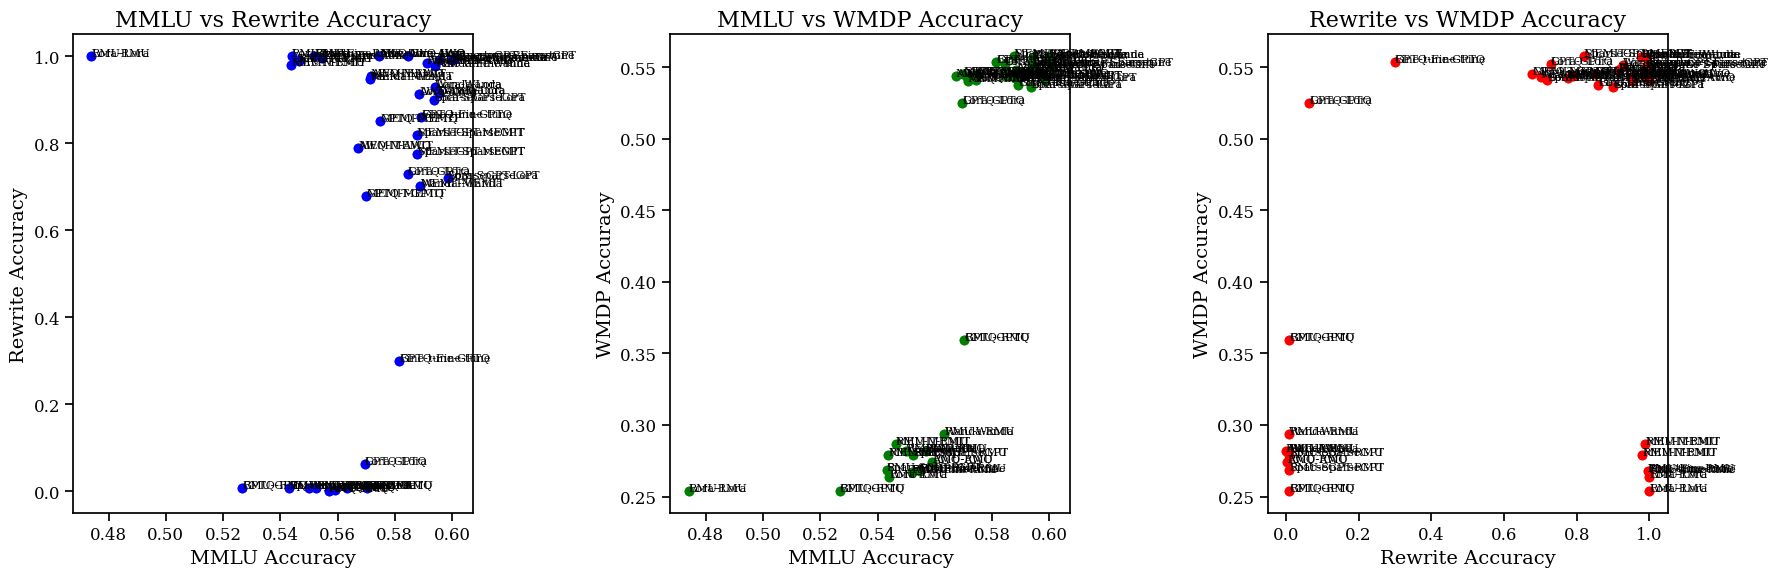

In [15]:
import matplotlib.pyplot as plt

# Parameters
sparsity_ratio = 0.25  # Tunable parameter for sparsity_ratio
wbits = 4  # Tunable parameter for wbits

intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "Lora": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn"
}
default_value = None

print(intervention_names)
intervention_names = ['Lora', 'Fine-tune', 'MEMIT', 'RMU', 'Wanda', 'SparseGPT', 'AWQ', 'GPTQ']

### DATA COLLECTION for scatter plots
scatter_data = {
    "mmlu": [],
    "wmdp": [],
    "rewrite": [],
    "pairs": []
}

for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == sparsity_ratio]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == wbits]

        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"

        mmlu_diff = compositions["mmlu accuracy"].tolist()
        scatter_data["mmlu"].extend(mmlu_diff)

        wmdp_diff = [(comp["wmdp_cyber accuracy"] + comp["wmdp_bio accuracy"]) / 2 for comp in compositions.to_dict('records')]
        scatter_data["wmdp"].extend(wmdp_diff)

        rewrite_diff = compositions["Rewrite accuracy"].tolist()
        scatter_data["rewrite"].extend(rewrite_diff)

        scatter_data["pairs"].extend([f"{first_intervention}-{second_intervention}", f"{second_intervention}-{first_intervention}"])

### PLOTTING SCATTER PLOTS
plt.rcParams['font.size'] = 14  # Adjust as desired for overall font size
plt.rcParams['axes.titlesize'] = 16  # Title font size
plt.rcParams['axes.labelsize'] = 14  # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # Tick label font size 
plt.rcParams['ytick.labelsize'] = 12  # Tick label font size 

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for MMLU vs Rewrite Accuracy
axes[0].scatter(scatter_data["mmlu"], scatter_data["rewrite"], color='blue')
axes[0].set_xlabel('MMLU Accuracy')
axes[0].set_ylabel('Rewrite Accuracy')
axes[0].set_title('MMLU vs Rewrite Accuracy')

# Annotate each point with the pair label
for i, txt in enumerate(scatter_data["pairs"]):
    axes[0].annotate(txt, (scatter_data["mmlu"][i], scatter_data["rewrite"][i]), fontsize=8)

# Scatter plot for MMLU vs WMDP Accuracy
axes[1].scatter(scatter_data["mmlu"], scatter_data["wmdp"], color='green')
axes[1].set_xlabel('MMLU Accuracy')
axes[1].set_ylabel('WMDP Accuracy')
axes[1].set_title('MMLU vs WMDP Accuracy')

# Annotate each point with the pair label
for i, txt in enumerate(scatter_data["pairs"]):
    axes[1].annotate(txt, (scatter_data["mmlu"][i], scatter_data["wmdp"][i]), fontsize=8)

# Scatter plot for Rewrite Accuracy vs WMDP Accuracy
axes[2].scatter(scatter_data["rewrite"], scatter_data["wmdp"], color='red')
axes[2].set_xlabel('Rewrite Accuracy')
axes[2].set_ylabel('WMDP Accuracy')
axes[2].set_title('Rewrite vs WMDP Accuracy')

# Annotate each point with the pair label
for i, txt in enumerate(scatter_data["pairs"]):
    axes[2].annotate(txt, (scatter_data["rewrite"][i], scatter_data["wmdp"][i]), fontsize=8)

plt.tight_layout()

if not os.path.exists("figures"):
    os.makedirs("figures")
plt.savefig("figures/scatter_plots.png", bbox_inches="tight")
plt.show()


## Plot: Composability Heatmaps

In [16]:
intervention_names = [intervention for intervention in list(data["edit"].unique()) + list(data["unlearn"].unique()) + list(data["compression"].unique()) if intervention is not None]
intervention_type = {
    "Lora": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn"
}
default_value = None

mmlu_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
rewrite_heatmap_data = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = data[(data[first_intervention_type] == first_intervention) & (data[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]

        # TODO: Known issue need to get more data
        if set([first_intervention, second_intervention]) == set(["Lora", "Wanda"]):
            continue
        
        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_heatmap_data[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_heatmap_data[first_intervention][second_intervention] = avg_wmdp_diff
        
        rewrite_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        rewrite_heatmap_data[first_intervention][second_intervention] = rewrite_diff
        
# print("MMLU")
# display(mmlu_heatmap_data)

# print("WMDP")
# display(wmdp_heatmap_data)

# print("Rewrite")
# display(rewrite_heatmap_data)

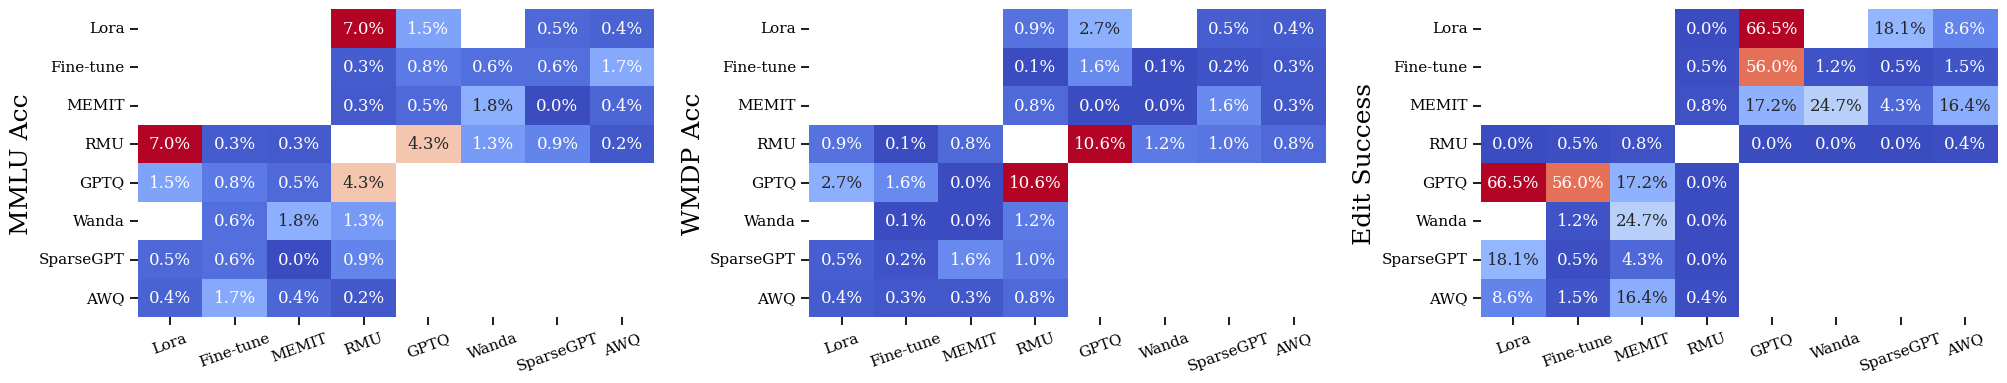

In [17]:
# Create three heatmaps next two eachother, one for each frame
fig, axes = plt.subplots(1, 3, figsize=(6 * FIG_SIZE, FIG_SIZE))
y_labels = {
    0: "MMLU Acc",
    1: "WMDP Acc",
    2: "Edit Success"
}

sns.heatmap(mmlu_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[0], cbar=False)
sns.heatmap(wmdp_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[1], cbar=False)
sns.heatmap(rewrite_heatmap_data, annot=True, fmt=".1%", cmap="coolwarm", ax=axes[2], cbar=False)

# roate x labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=X_LABEL_ROTATION)

for i, ax in enumerate(axes):
    ax.set_ylabel(y_labels[i], fontsize=TITLE_FONT_SIZE)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

if not os.path.exists("figures"):
    os.makedirs("figures")

plt.savefig("figures/delta_heatmaps.pdf", bbox_inches="tight")

## Plot: Unlearning under Compression 

### 2x2

/tmp/ipykernel_76299/2246241194.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
/tmp/ipykernel_76299/2246241194.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/tmp/ipykernel_76299/2246241194.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

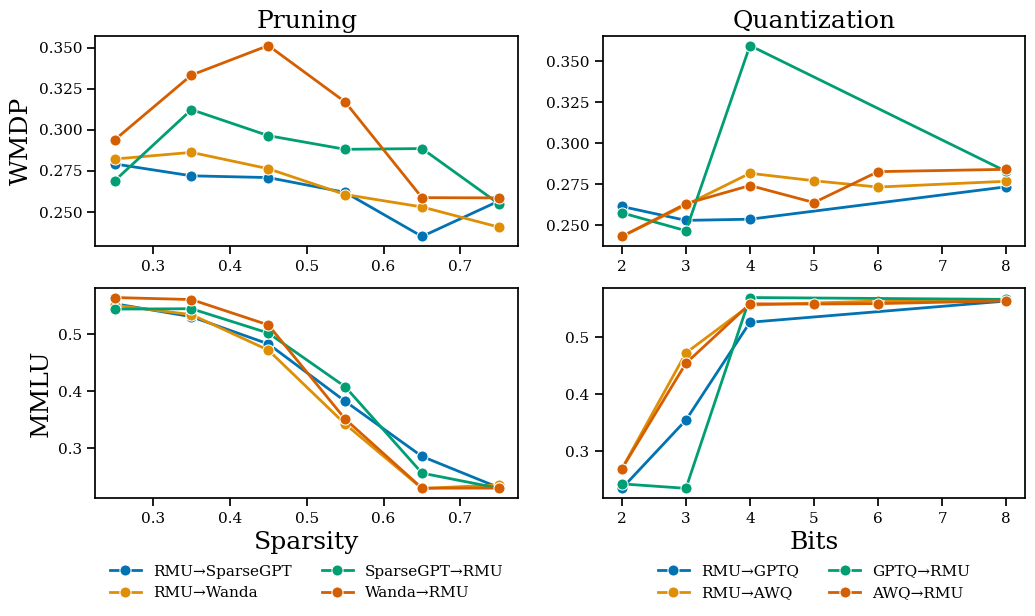

In [13]:
# NOTE: Inspired by the 3X3 line charts in the existing paper

def get_order_label(row):
    interventions = row["interventions"]
    first_method = ""
    second_method = ""
    if interventions[0] == "edit":
        first_method = row["edit"]
    elif interventions[0] == "compress":
        first_method = row["compression"]
    elif interventions[0] == "unlearn":
        first_method = row["unlearn"]
    
    if interventions[1] == "edit":
        second_method = row["edit"]
    elif interventions[1] == "compress":
        second_method = row["compression"]
    elif interventions[1] == "unlearn":
        second_method = row["unlearn"]

    return f"{first_method}→{second_method}"

pruning_frame = data[((data["compression"] == "SparseGPT") | (data["compression"] == "Wanda")) & (data["unlearn"] == "RMU")]
pruning_frame["Avg WMDP"] = (pruning_frame["wmdp_bio accuracy"] + pruning_frame["wmdp_cyber accuracy"]) / 2
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = data[((data["compression"] == "GPTQ") | (data["compression"] == "AWQ")) & (data["unlearn"] == "RMU")]
quantization_frame["Avg WMDP"] = (quantization_frame["wmdp_bio accuracy"] + quantization_frame["wmdp_cyber accuracy"]) / 2
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order", ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(3 * FIG_SIZE, 1.5 * FIG_SIZE))
row_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
}

for row_index, row_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, quantization_frame]):
        x_metric = "sparsity_ratio" if col_index == 0 else "wbits"
        ax = axes[row_index][col_index]
        ax.legend(title="Order", loc="upper left")
        sns.lineplot(data=plotting_frame, x=x_metric, y=row_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

        if row_index == 0:
            title = "Pruning" if col_index == 0 else "Quantization"
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
            ax.set_xlabel("")
            ax.get_legend().remove()
        else:
            x_label = "Sparsity" if col_index == 0 else "Bits"
            ax.set_xlabel(x_label, fontsize=TITLE_FONT_SIZE)
            ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False)
        
        if col_index == 0:
            y_label = "WMDP" if row_index == 0 else "MMLU"
            ax.set_ylabel(y_label, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")
        
# add padding for labels
fig.subplots_adjust()
plt.savefig("figures/unlearning_compression_2x2.pdf", bbox_inches="tight")


#### Note: Seeing strange results with gptq4bit-rmu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


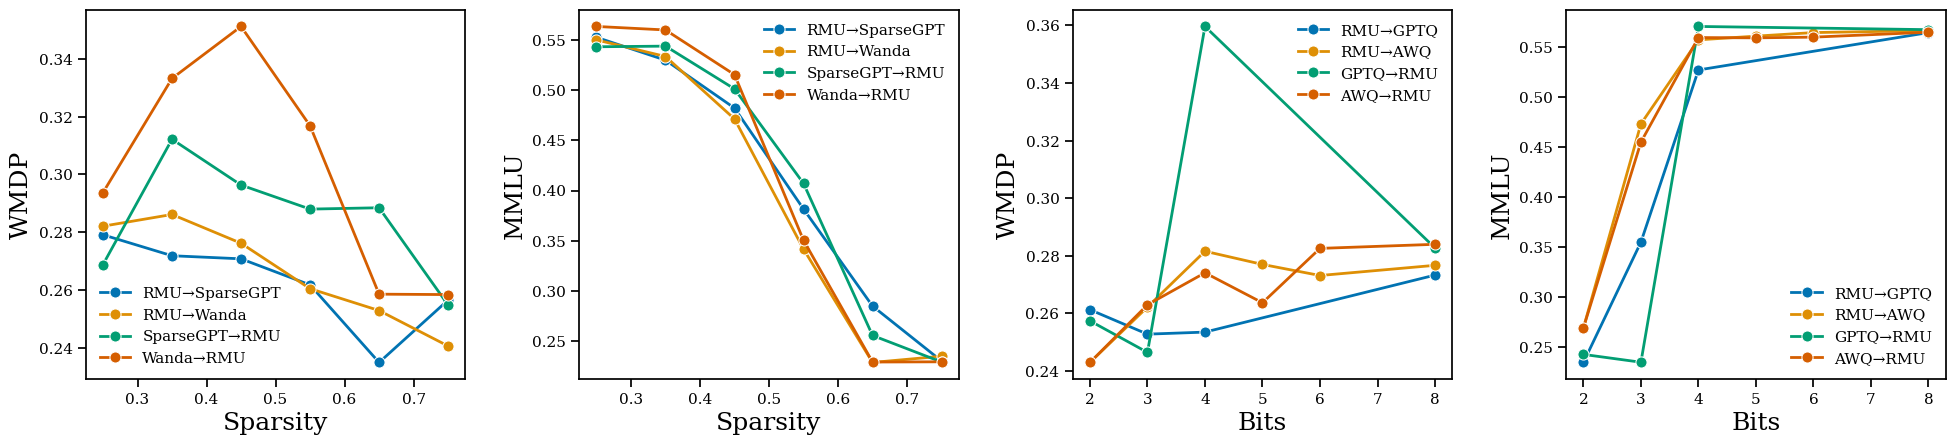

In [14]:
# Inspired by the 3X3 line charts in the existing paper

fig, axes = plt.subplots(1, 4, figsize=(6 * FIG_SIZE, 1.2 * FIG_SIZE))
column_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
    2: "Avg WMDP",
    3: "mmlu accuracy",
}
x_labels = {
    "sparsity_ratio": "Sparsity",
    "wbits": "Bits"
}
y_label = {
    "Avg WMDP": "WMDP",
    "mmlu accuracy": "MMLU"
}

# Custom legend elements
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=MARKER_SIZE, label='Edit→Compress'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=MARKER_SIZE, label='Compress→Edit'),
]

for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, quantization_frame, quantization_frame]):
    x_metric = "sparsity_ratio" if col_index < 2 else "wbits"
    y_metric = "Avg WMDP" if col_index % 2 == 0 else "mmlu accuracy"
    ax = axes[col_index]
    ax.legend(title="Order", loc="upper left")
    sns.lineplot(data=plotting_frame, x=x_metric, y=y_metric, hue="order", ax=ax, marker="o", markersize=MARKER_SIZE, linewidth=LINE_WIDTH)

    ax.set_xlabel(x_labels[x_metric], fontsize=TITLE_FONT_SIZE)
    ax.set_ylabel(y_label[column_metrics[col_index]], fontsize=TITLE_FONT_SIZE)
    ax.legend(frameon=False)
    # TODO: Color shared between compositions
    # TODO: Conssistently color compositions 
        
# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/unlearning_compression_1x4.pdf", bbox_inches="tight")


NameError: name 'edit_then_compress_baselines' is not defined

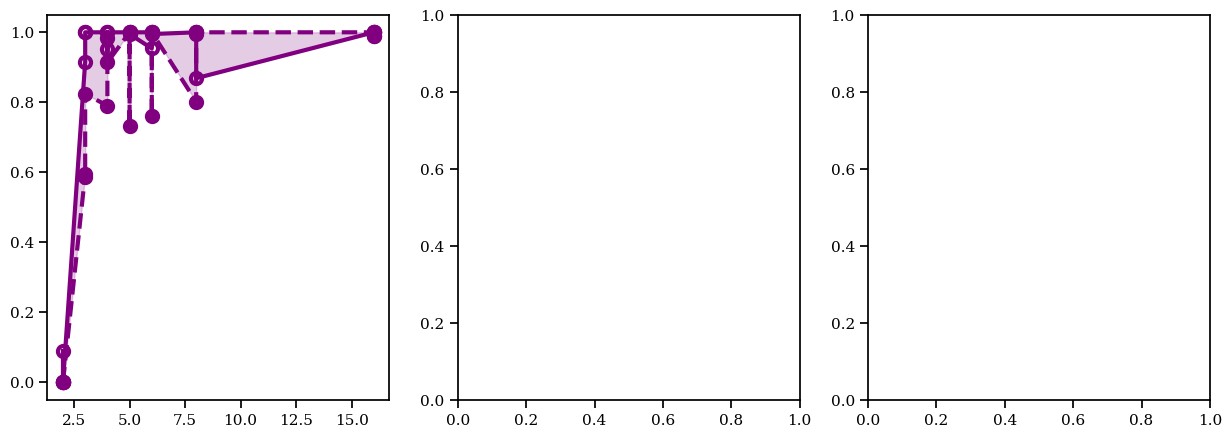

In [14]:



# Assuming 'metrics' DataFrame is already loaded from the CSV

# Define the criteria for filtering
selected_method = 'AWQ'
edit_method = ["FT"]

# Filter based on the criteria
edit_then_compress = categories['Edit to Compression']
compress_then_edit = categories['Compression to Edit']

# Filter based on selected method
edit_then_compress = edit_then_compress[edit_then_compress['compression']==selected_method]
compress_then_edit = compress_then_edit[compress_then_edit['compression']==selected_method]

# Add baselines to dfs
baseline = categories['Editing']
baseline['wbits'] = 16
edit_then_compress = pd.concat([edit_then_compress, baseline], axis=0)
compress_then_edit = pd.concat([compress_then_edit, baseline], axis=0)

# Sort by 'wbits' in ascending order
edit_then_compress = edit_then_compress.sort_values(by='wbits')
compress_then_edit = compress_then_edit.sort_values(by='wbits')

# Define the metrics to plot
metrics_to_plot = ['Rewrite accuracy', 'Generalization', 'mmlu']
x_axis_metric = 'wbits'

# Compute baselines
# edit_then_compress_baselines = {model: edit_then_compress[(edit_then_compress['model_name'] == model) & (edit_then_compress['sparsity_ratio'] == 0)][metrics_to_plot].mean() for model in included_models}
# compress_then_edit_baselines = {model: compress_then_edit[(compress_then_edit['model_name'] == model) & (compress_then_edit['sparsity_ratio'] == 0)][metrics_to_plot].mean() for model in included_models}
# edit_then_compress_baselines = categories['No Intervention']
# compress_then_edit_baselines = categories['No Intervention']

# Define plot parameters
title_fontsize = 20
label_fontsize = 20
legend_fontsize = 18
tick_fontsize = 18
line_width = 3
marker_size = 8

included_models = ["Llama-3 (8b)"]

# Create subplots
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(15, 5))

# Iterate over each metric and plot
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Plot the data with scatter and lines
    ax.plot(edit_then_compress['wbits'], edit_then_compress[metric], linestyle='--', marker='o', markerfacecolor='purple', color='purple', label='Edit then compress',
            linewidth=line_width, markersize=marker_size, markeredgewidth=line_width)
    ax.plot(compress_then_edit['wbits'], compress_then_edit[metric], linestyle='-', marker='o', markerfacecolor='none', color='purple', label='Compress then edit',
            linewidth=line_width, markersize=marker_size, markeredgewidth=line_width)
    
    # Fill the area between the lines
    ax.fill_between(edit_then_compress['wbits'], edit_then_compress[metric], compress_then_edit[metric], color='purple', alpha=0.2)
    
    # Integrate baselines into the scatter plots
    for model in included_models:
        baseline_edit = edit_then_compress_baselines[metric]
        baseline_compress = compress_then_edit_baselines[metric]
        
        if x_axis_metric == 'Average bits':
            baseline_x = 16
            ax.set_xlim(2, 16)
        elif x_axis_metric == 'sparsity_ratio':
            baseline_x = 0.0
            ax.set_xlim(0, 1)
        else:
            baseline_x = 0  # Adjust based on your default x-axis range

        # Add baselines to the scatter plots
        # ax.scatter([baseline_x], [baseline_edit], color='purple', marker='o', s=marker_size**2, edgecolor='purple', linewidth=line_width)
        # ax.scatter([baseline_x], [baseline_compress], color='purple', marker='o', s=marker_size**2, edgecolor='purple', linewidth=line_width)
    if x_axis_metric == 'wbits':
        ax.set_xlabel('Bits', fontsize=label_fontsize)
    else:
        ax.set_xlabel(x_axis_metric, fontsize=label_fontsize)
    if metric == 'Rewrite accuracy':
        ax.set_ylabel('Edit success', fontsize=label_fontsize)
    else:
        ax.set_ylabel(metric, fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Move the legend to the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=legend_fontsize, ncol=2)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the bottom margin to make space for the legend
plt.show()
plt.savefig('figures/memit-gptq.pdf', format='pdf')
